In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.17.0


In [2]:
'''
a. Get the data
b. Data Pre-preprocessing
'''
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

In [3]:
train_images = np.reshape(train_images, (-1, 28, 28, 1))
test_images = np.reshape(test_images, (-1, 28, 28, 1))

In [4]:
train_jungyu = {'images': train_images, 'labels': train_labels}
test_jungyu = {'images': test_images, 'labels': test_labels}

In [5]:
print(f"Train images shape: {train_jungyu['images'].shape}")
print(f"Test images shape: {test_jungyu['images'].shape}")

Train images shape: (60000, 28, 28, 1)
Test images shape: (10000, 28, 28, 1)


In [6]:
'''
c. Build Variational Autoencoder with latent dimension size of 2
c-1. custom sample layer
'''
class SampleLayer(layers.Layer):
    def call(self, inputs):
        z_mu, z_log_sigma = inputs
        batch = tf.shape(z_mu)[0] 
        dim = tf.shape(z_mu)[1]
        
        # reparameterization trick
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        z = z_mu + tf.exp(0.5 * z_log_sigma) * epsilon
        
        return z

In [7]:
'''
c-2. Build the encoder
c-3. Print the summary
'''
input_img = layers.Input(shape=(28, 28, 1))

x = layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(input_img)
x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', strides=(2, 2))(x)
x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

# latent variables: mean and log variance
z_mu_jungyu = layers.Dense(2, name='z_mu_jungyu')(x)
z_log_sigma_jungyu = layers.Dense(2, name='z_log_sigma_jungyu')(x)

z_jungyu = SampleLayer()([z_mu_jungyu, z_log_sigma_jungyu])

encoder_jungyu = tf.keras.Model(input_img, [z_mu_jungyu, z_log_sigma_jungyu, z_jungyu], name="encoder")
encoder_jungyu.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                ┃ Output Shape            ┃        Param # ┃ Connected to             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)    │ (None, 28, 28, 1)       │              0 │ -                        │
├─────────────────────────────┼─────────────────────────┼────────────────┼──────────────────────────┤
│ conv2d (Conv2D)             │ (None, 28, 28, 32)      │            320 │ input_layer[0][0]        │
├─────────────────────────────┼─────────────────────────┼────────────────┼──────────────────────────┤
│ conv2d_1 (Conv2D)           │ (None, 14, 14, 64)      │         18,496 │ conv2d[0][0]             │
├─────────────────────────────┼─────────────────────────┼────────────────┼──────────────────────────┤
│ conv2d_2 (Conv2D)           │ (None, 14, 14, 64)      │         36,928 │ conv2d_1[0][0]           │
├─────────────────────────────┼─────────────────────────┼────────────────┼──────────────────────────┤
│ conv2d_3 (Conv2D)           │ (None, 14, 14, 64)      │         36,928 │ conv2d_2[0][0]           │
├─────────────────────────────┼─────────────────────────┼────────────────┼──────────────────────────┤
│ flatten (Flatten)           │ (None, 12544)           │              0 │ conv2d_3[0][0]           │
├─────────────────────────────┼─────────────────────────┼────────────────┼──────────────────────────┤
│ dense (Dense)               │ (None, 32)              │        401,440 │ flatten[0][0]            │
├─────────────────────────────┼─────────────────────────┼────────────────┼──────────────────────────┤
│ z_mu_jungyu (Dense)         │ (None, 2)               │             66 │ dense[0][0]              │
├─────────────────────────────┼─────────────────────────┼────────────────┼──────────────────────────┤
│ z_log_sigma_jungyu (Dense)  │ (None, 2)               │             66 │ dense[0][0]              │
├─────────────────────────────┼─────────────────────────┼────────────────┼──────────────────────────┤
│ sample_layer (SampleLayer)  │ (None, 2)               │              0 │ z_mu_jungyu[0][0],       │
│                             │                         │                │ z_log_sigma_jungyu[0][0] │
└─────────────────────────────┴─────────────────────────┴────────────────┴──────────────────────────┘

 Total params: 494,244 (1.89 MB)

 Trainable params: 494,244 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
'''
c-4. Build the decoder
c-5. Print the summary
'''
latent_inputs = layers.Input(shape=(2,))

x = layers.Dense(14 * 14 * 64, activation='relu')(latent_inputs)
x = layers.Reshape((14, 14, 64))(x)

x = layers.Conv2DTranspose(64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = layers.Conv2DTranspose(64, kernel_size=(3, 3), activation='relu', padding='same', strides=(2, 2))(x)
x = layers.Conv2DTranspose(32, kernel_size=(3, 3), activation='relu', padding='same')(x)

output_img = layers.Conv2DTranspose(1, kernel_size=(3, 3), activation='sigmoid', padding='same')(x)

decoder_jungyu = tf.keras.Model(latent_inputs, output_img, name="decoder")
decoder_jungyu.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 12544)               │          37,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 28, 28, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 130,241 (508.75 KB)

 Trainable params: 130,241 (508.75 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
'''
c-6. Build a variational autoencoders
c-7. Print the summary
d. Define the KL divergence
e. Use model.add_loss() to add the KL loss function defined in Step D
f. Compile the model with 'adam' optimizer, and 'mean_square_error' loss function
'''
class KLDivergenceLayer(layers.Layer):
    def call(self, inputs):
        z_mu, z_log_sigma = inputs
        kl_loss = -0.5 * tf.reduce_mean(1 + z_log_sigma - tf.square(z_mu) - tf.exp(z_log_sigma))
        self.add_loss(kl_loss) 
        return inputs  

vae_input = encoder_jungyu.input  

z_mu_jungyu, z_log_sigma_jungyu, z_jungyu = encoder_jungyu(vae_input)


kl_layer = KLDivergenceLayer()([z_mu_jungyu, z_log_sigma_jungyu])

vae_output = decoder_jungyu(z_jungyu)

vae_jungyu = tf.keras.Model(vae_input, vae_output, name="vae")

vae_jungyu.compile(optimizer='adam', loss='mean_squared_error')

vae_jungyu.summary()

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder (Functional)                 │ [(None, 2), (None, 2),      │         494,244 │
│                                      │ (None, 2)]                  │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Functional)                 │ (None, 28, 28, 1)           │         130,241 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 624,485 (2.38 MB)

 Trainable params: 624,485 (2.38 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
'''
g. Use TensorFlow's fit() and the train_firstname['images' dataset to train the VAE
with 10 epochs and batch size of 256. 
'''
vae_jungyu.fit(train_jungyu['images'], train_jungyu['images'], epochs=10, batch_size=256)

Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 66s 281ms/step - loss: 0.0301
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 58s 248ms/step - loss: 0.0291
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 59s 249ms/step - loss: 0.0286
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 57s 243ms/step - loss: 0.0282
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 67s 286ms/step - loss: 0.0276
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 63s 267ms/step - loss: 0.0276
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 68s 289ms/step - loss: 0.0272
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 67s 287ms/step - loss: 0.0271
Epoch 9/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 67s 286ms/step - loss: 0.0269
Epoch 10/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 62s 265ms/step - loss: 0.0270


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


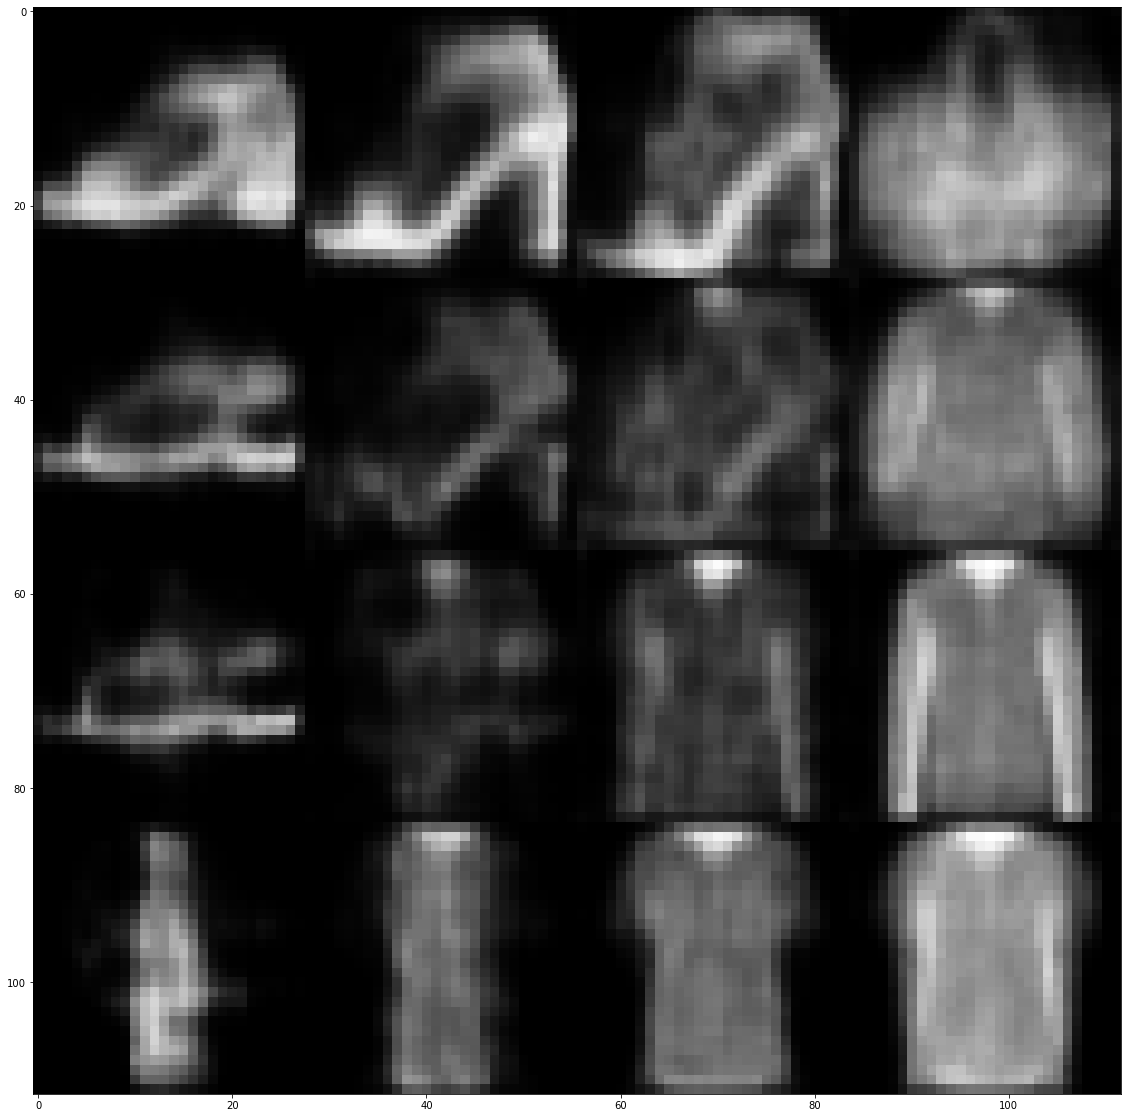

In [23]:
'''
h. Review sample code below and generate 10x10 samples from the VAE model using the decoder.
reconstructed images sampled from the latent space
'''

import tensorflow_probability as tfp

n = 4
figure_size = 28
norm = tfp.distributions.Normal(0, 1)
grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
grid_y = norm.quantile(np.linspace(0.05, 0.95, n))

figure = np.zeros((figure_size * n, figure_size * n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder_jungyu.predict(z_sample)
        img = x_decoded[0].reshape(28, 28)
        figure[i * figure_size: (i + 1) * figure_size,
               j * figure_size: (j + 1) * figure_size] = img

plt.figure(figsize=(20, 20))
plt.imshow(figure, cmap='Greys_r')
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


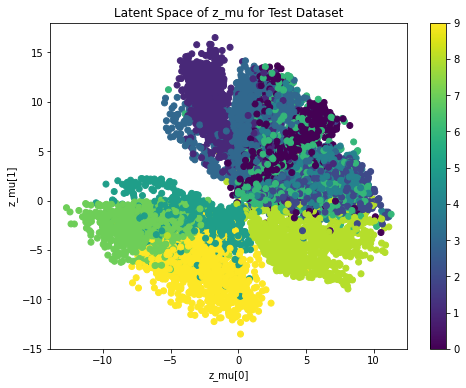

In [24]:
'''
i. Display (plot) the latent space of z_mu of the test dataset
'''
z_mu_model = tf.keras.Model(encoder_jungyu.input, z_mu_jungyu)

z_mu_test = z_mu_model.predict(test_jungyu['images'])

plt.figure(figsize=(8, 6))

plt.scatter(z_mu_test[:, 0], z_mu_test[:, 1], c=test_jungyu['labels'], cmap='viridis')

plt.colorbar()
plt.xlabel('z_mu[0]')
plt.ylabel('z_mu[1]')
plt.title('Latent Space of z_mu for Test Dataset')

plt.show()